# Proteomica LC–MS/MS: dati LFQ, QC e analisi differenziale

Obiettivi del notebook:
- Simulare un piccolo dataset di **proteomica label-free (LFQ)** con campioni controllo vs esposti.
- Eseguire passi base di **QC e normalizzazione**.
- Calcolare una semplice **analisi differenziale** (fold change + t-test).
- Visualizzare i risultati con un **volcano plot**.

_Tutti i dati sono simulati per fini didattici, ispirati a un output di MaxQuant/Proteome Discoverer._

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline
np.random.seed(123)

## 1. Simulazione di un dataset proteomico LFQ

Impostiamo:
- 400 proteine
- 8 campioni (4 controlli, 4 esposti) – es. organismi in acqua pulita vs in acqua inquinata
- maggior parte delle proteine: nessuna differenza tra gruppi
- piccolo set di proteine "stress-response" con aumento di abbondanza nel gruppo esposto

Simuleremo intensità LFQ su scala log₂ (come spesso in MaxQuant/Perseus).

In [2]:
n_prot = 400
n_ctrl = 4
n_exp = 4
n_samples = n_ctrl + n_exp

sample_ids = [f"CTRL_{i+1}" for i in range(n_ctrl)] + [f"EXP_{i+1}" for i in range(n_exp)]
conditions = pd.Series(
    ["CTRL"]*n_ctrl + ["EXP"]*n_exp,
    index=sample_ids,
    name="condition",
)

# Identificativi proteici fittizi
protein_ids = [f"P{10000+i}" for i in range(n_prot)]
gene_names = [f"GENE_{i}" for i in range(n_prot)]

# Intensità log2 di base ~ N(25, 1.2)
log2_intensities = np.random.normal(loc=25, scale=1.2, size=(n_prot, n_samples))

# Selezioniamo 20 proteine "ambientalmente responsive" con aumento di ~1.5 in log2 (≈ FC ~2.8)
n_de = 20
de_idx = np.random.choice(np.arange(n_prot), size=n_de, replace=False)
for idx in de_idx:
    log2_intensities[idx, conditions == "EXP"] += 1.5

# Aggiungiamo missing values: più frequenti nelle proteine meno abbondanti
missing_mask = np.zeros_like(log2_intensities, dtype=bool)
base_mean = log2_intensities.mean(axis=1)
prob_missing = np.interp(base_mean, (base_mean.min(), base_mean.max()), (0.4, 0.02))
for i in range(n_prot):
    for j in range(n_samples):
        if np.random.rand() < prob_missing[i]:
            missing_mask[i, j] = True
log2_intensities_masked = log2_intensities.copy()
log2_intensities_masked[missing_mask] = np.nan

# Costruiamo un DataFrame tipo proteinGroups
intensity_cols = [f"LFQ_{sid}" for sid in sample_ids]
data = pd.DataFrame(log2_intensities_masked, columns=intensity_cols)
data.insert(0, "Gene", gene_names)
data.insert(0, "ProteinID", protein_ids)
data.head()

,ProteinID,Gene,LFQ_CTRL_1,LFQ_CTRL_2,LFQ_CTRL_3,LFQ_CTRL_4,LFQ_EXP_1,LFQ_EXP_2,LFQ_EXP_3,LFQ_EXP_4
0,P10000,GENE_0,23.697243,26.196815,25.339574,23.192446,24.305680,26.981724,NaN,NaN
1,P10001,GENE_1,26.519124,23.959912,24.185337,24.886349,26.789668,24.233318,24.467222,24.478778
2,P10002,GENE_2,27.647116,27.624143,26.204865,25.463424,25.884842,26.788878,23.876999,26.410995
3,P10003,GENE_3,NaN,24.234698,NaN,23.285583,24.831918,NaN,NaN,21.641693
4,P10004,GENE_4,22.874160,24.160147,26.112955,24.791637,NaN,25.825867,23.944556,25.340353


## 2. QC semplice: numero di proteine quantificate per campione

Contiamo, per ciascun campione, quante proteine hanno un'intensità non missing.

In [3]:
counts_per_sample = data[intensity_cols].notna().sum(axis=0)
counts_per_sample

LFQ_CTRL_1    325
LFQ_CTRL_2    318
LFQ_CTRL_3    324
LFQ_CTRL_4    319
LFQ_EXP_1     317
LFQ_EXP_2     311
LFQ_EXP_3     329
LFQ_EXP_4     315
dtype: int64

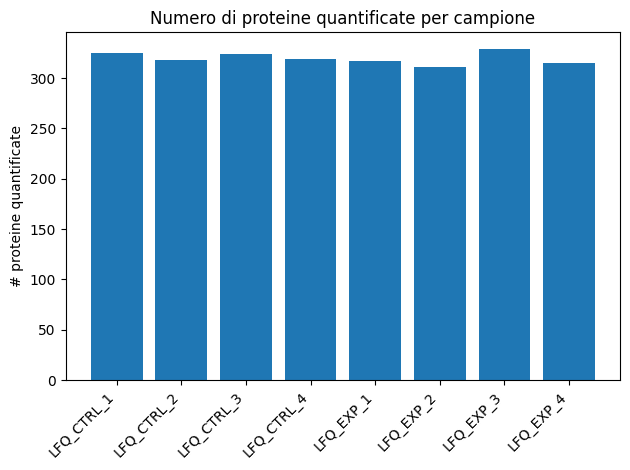

In [4]:
plt.bar(range(len(intensity_cols)), counts_per_sample.values)
plt.xticks(range(len(intensity_cols)), intensity_cols, rotation=45, ha="right")
plt.ylabel("# proteine quantificate")
plt.title("Numero di proteine quantificate per campione")
plt.tight_layout()
plt.show()

## 3. Distribuzione delle intensità log₂ per campione

Guardiamo rapidamente la distribuzione delle intensità per i campioni controllo vs esposti.

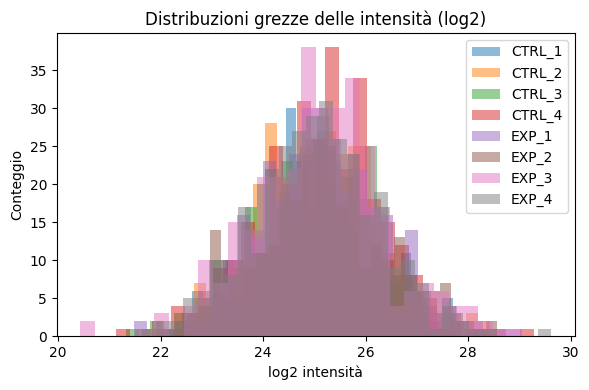

In [5]:
plt.figure(figsize=(6,4))
for sid in sample_ids:
    col = f"LFQ_{sid}"
    plt.hist(data[col].dropna(), bins=30, alpha=0.5, label=sid)
plt.xlabel("log2 intensità")
plt.ylabel("Conteggio")
plt.title("Distribuzioni grezze delle intensità (log2)")
plt.legend()
plt.tight_layout()
plt.show()

In dataset reali, differenze sistematiche tra campioni portano alla necessità di **normalizzazione**.

## 4. Normalizzazione semplice (centered log2)

Applichiamo una normalizzazione molto semplice:
- per ogni campione, sottraiamo la mediana delle intensità non-mancanti
- questo centra le distribuzioni attorno allo stesso valore.

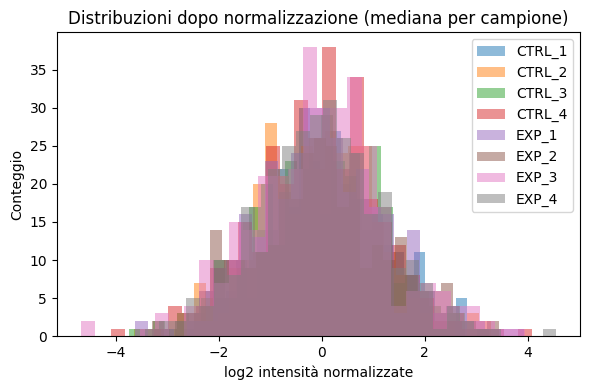

In [6]:
norm_data = data.copy()
for col in intensity_cols:
    med = norm_data[col].median(skipna=True)
    norm_data[col] = norm_data[col] - med

plt.figure(figsize=(6,4))
for sid in sample_ids:
    col = f"LFQ_{sid}"
    plt.hist(norm_data[col].dropna(), bins=30, alpha=0.5, label=sid)
plt.xlabel("log2 intensità normalizzate")
plt.ylabel("Conteggio")
plt.title("Distribuzioni dopo normalizzazione (mediana per campione)")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Filtraggio di proteine con troppi missing

Per una semplice analisi differenziale richiediamo, ad esempio:
- almeno 3 valori non-mancanti su 4 in ciascun gruppo (CTRL/EXP).

In [11]:
ctrl_cols = [f"LFQ_CTRL_{i+1}" for i in range(n_ctrl)]
exp_cols = [f"LFQ_EXP_{i+1}" for i in range(n_exp)]

mask_ctrl = norm_data[ctrl_cols].notna().sum(axis=1) >= 3
mask_exp = norm_data[exp_cols].notna().sum(axis=1) >= 3
keep = mask_ctrl & mask_exp

filtered = norm_data.loc[keep].copy()
print(f"Proteine totali: {len(norm_data)}")
print(f"Proteine dopo filtro missing: {len(filtered)}")

Proteine totali: 400
Proteine dopo filtro missing: 262


## 6. Analisi differenziale: log₂ fold change e t-test

Per ogni proteina filtrata:
- calcoliamo la media per gruppo (CTRL, EXP)
- log2 fold-change = EXP_mean − CTRL_mean
- eseguiamo un t-test tra i due gruppi (usando le intensità normalizzate)

_Nota_: è un esempio semplificato; in analisi reali si usano modelli più robusti (limma, MSstats, DEP, ecc.).

In [13]:
results = []
for idx, row in filtered.iterrows():
    # Convert per-row to numeric floats
    vals_ctrl = pd.to_numeric(row[ctrl_cols], errors="coerce").to_numpy(dtype=float)
    vals_exp  = pd.to_numeric(row[exp_cols],  errors="coerce").to_numpy(dtype=float)

    mean_ctrl = np.nanmean(vals_ctrl)
    mean_exp  = np.nanmean(vals_exp)

    # Note: this is actually a difference, not log2 fold-change
    log2_fc = mean_exp - mean_ctrl

    # Optionally guard against all-NaN or too-few points
    if np.isnan(vals_ctrl).all() or np.isnan(vals_exp).all():
        pval = np.nan
    else:
        tstat, pval = stats.ttest_ind(
            vals_exp,
            vals_ctrl,
            equal_var=False,
            nan_policy="omit",
        )

    results.append({
        "ProteinID": row["ProteinID"],
        "Gene": row["Gene"],
        "mean_CTRL": mean_ctrl,
        "mean_EXP": mean_exp,
        "log2_FC_EXP_vs_CTRL": log2_fc,
        "pval": pval,
    })

res_df = pd.DataFrame(results)


Aggiungiamo anche il valore −log10(p-value) per il volcano plot.

In [14]:
res_df["neg_log10_pval"] = -np.log10(res_df["pval"])
res_df.head()

,ProteinID,Gene,mean_CTRL,mean_EXP,log2_FC_EXP_vs_CTRL,pval,neg_log10_pval
0,P10001,GENE_1,-0.184508,-0.111221,0.073287,0.935706,0.028861
1,P10002,GENE_2,1.662698,0.636961,-1.025737,0.287018,0.542091
2,P10004,GENE_4,-0.587464,-0.064045,0.523419,0.566475,0.246820
3,P10005,GENE_5,-0.300970,0.196280,0.497250,0.347799,0.458672
4,P10006,GENE_6,0.740160,0.509927,-0.230233,0.880092,0.055472


## 7. Volcano plot

Costruiamo un volcano plot con:
- asse X: log₂ fold change
- asse Y: −log₁₀(p-value)

Impostiamo soglie indicative:
- |log₂FC| ≥ 1 (≈ FC ≥ 2)
- p-value ≤ 0.01 (≈ −log₁₀(p) ≥ 2)

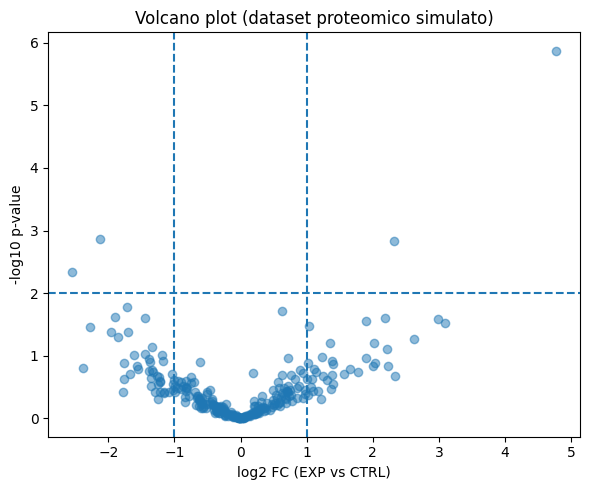

In [15]:
log2fc = res_df["log2_FC_EXP_vs_CTRL"]
neglogp = res_df["neg_log10_pval"]

plt.figure(figsize=(6,5))
plt.scatter(log2fc, neglogp, alpha=0.5)
plt.axvline(1, linestyle="--")
plt.axvline(-1, linestyle="--")
plt.axhline(2, linestyle="--")
plt.xlabel("log2 FC (EXP vs CTRL)")
plt.ylabel("-log10 p-value")
plt.title("Volcano plot (dataset proteomico simulato)")
plt.tight_layout()
plt.show()

## 8. Selezionare proteine candidate responsive all'ambiente

Applichiamo le soglie:
- |log₂FC| ≥ 1
- p-value ≤ 0.01

In [16]:
fc_thresh = 1.0
p_thresh = 0.01

hits = res_df[(res_df["log2_FC_EXP_vs_CTRL"].abs() >= fc_thresh) & (res_df["pval"] <= p_thresh)]
print(f"Numero di proteine candidate: {len(hits)}")
hits.sort_values("pval").head(20)

Numero di proteine candidate: 4


,ProteinID,Gene,mean_CTRL,mean_EXP,log2_FC_EXP_vs_CTRL,pval,neg_log10_pval
234,P10350,GENE_350,-1.274214,3.495666,4.769881,0.000001,5.871160
72,P10117,GENE_117,0.794064,-1.333185,-2.127249,0.001385,2.858425
45,P10071,GENE_71,0.205556,2.529596,2.324039,0.001462,2.834958
7,P10010,GENE_10,1.437413,-1.107161,-2.544575,0.004590,2.338181


In un contesto **ambientale/climatico**, queste proteine potrebbero rappresentare:
- proteine da stress ossidativo (es. per esposizione a metalli o inquinanti)
- chaperoni (HSP) attivati da stress termico
- enzimi di detossificazione o risposta infiammatoria

Qui abbiamo visto la logica base: da dati LC–MS/MS quantitativi → liste di proteine differenzialmente abbondanti.

Da qui si può proseguire con:
- analisi di arricchimento di pathway (GO, KEGG, Reactome)
- integrazione con altri livelli omici (trascrittomica, metabolomica).